# S learner Uplift model

Uplift model koji koristi meta-learner *S-Learner* za heterogeni efekat individualnog tretmana (ITE) i marketinsku segmentaciju kupaca.
S-Learner je meta-learner koji koristi jedan model masinskog ucenja za procenu efekta kauzalnog tretmana na individualnom nivou.

In [0]:
#install package

!pip install causalml

Looking in indexes: https://artifacts.rbi.tech/artifactory/api/pypi/pypi-org-pypi-proxy/simple/
     |████████████████████████████████| 535 kB 32.0 MB/s 
     |████████████████████████████████| 76 kB 7.4 MB/s 
     |▍              

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 42.1 MB 25 kB/s 
     |████████████████████████████████| 536 kB 61.8 MB/s 
  Created wheel for causalml: filename=causalml-0.13.0-cp39-cp39-linux_x86_64.whl size=1795514 sha256=f8e7f531c8acb004cd7468f9f277aacfff59cff818cd68ee8e58c22c21314842
  Stored in directory: /root/.cache/pip/wheels/16/ef/d4/7a35226eab82497e4ce41e48f2b5abc71b69d0863b37671e84
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24575 sha256=38b01a3a519e87d7cdce0d772b85b367cdd1f2debe41c726588df93c79802ede
  Stored in directory: /root/.cache/pip/wheels/ca/2b/0a/7ce5639f9af8037477db6f113b129bf42c2ccf27bdb880936f
  Created wheel for future: filename=future-0.18.3-py3

In [0]:
#Data processing
import pandas as pd
import numpy as np

#Create synthetic data
from causalml.dataset import synthetic_data

#Visualization
import seaborn as sns

#Machine Learning model
from lightgbm import LGBMRegressor

/local_disk0/.ephemeral_nfs/envs/pythonEnv-860cd165-2452-4c7d-82a9-044a74f1a954/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/local_disk0/.ephemeral_nfs/envs/pythonEnv-860cd165-2452-4c7d-82a9-044a74f1a954/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#depr

Kreiracemo sinteticki skup podataka za uplift model koriscenjem S-Learnera.
Koristimo *synthetic_data* metodu iz paketa *causal_ml* i kreiramo skup podataka sa 5 karakteristika, jednom promenljivom koja predstavlja da li je klijent dobio tretman i jednom kontinualnom varijablom ishoda.
U odnosu na varijablu *treatment* klijenti su podjednako rasporedjeni.

In [0]:
# Set a seed for reproducibility
np.random.seed(42)

# Create a synthetic dataset
y, X, treatment, _, _, _ = synthetic_data(mode=1, n=1000, p=5, sigma=1.0)

# Save the data in a pandas dataframe
df = pd.DataFrame({'y': y, 'X1': X.T[0], 'X2': X.T[1], 'X3': X.T[2], 'X4': X.T[3], 'X5': X.T[4], 'treatment': treatment})

# Check treatment
df['treatment'].value_counts()

Out[3]: 1    512
0    488
Name: treatment, dtype: int64

### S-Learner Treniranje modela

S-Learner trenira jedan model masinskog ucenja.

In [0]:
# Features
features = df.loc[:, ['X1', 'X2', 'X3', 'X4', 'X5', 'treatment']]

# Dependent variable
y = df.loc[:, ['y']]

Izbor modela i podesavanje hiperparametara su vazni za performanse S-Learnera. To je zato sto performanse modela uticu na predvidjanje modela, a samim tim i na tacnost procene individualnog efekta tretmana (ITE).

Mnogi algoritmi ML se mogu koristiti za izgradju S-Learnera. U ovom primeru cemo koristiti light GBM model.

In [0]:
# Initiate the light GBM model
s_learner = LGBMRegressor()

# Fit the model
s_learner.fit(features, y);

### S-Learner Predvidjanje modela

Da bi se izvrsila procena efekta tretmana, potrebno je napraviti dva odvojena predvidjanja koristeci obuceni model.

U prvom predvidjanju, varijabla tretmana je postavljena na 1 za sve uzorke. Ovo nam daje predvidjene vrednosti ishoda ako su svi uzorci dobili tretman.

U drugom predvidjanju, varijabla tretmana je postavljena na 0 za sve uzorke. Ovo nam daje predvidjene vrednosti ishoda ako nijedan od uzoraka nije dobio tretman.

In [0]:
# Set treatment value to 1
with_treatment = features.assign(treatment = 1)
# With treatment predictions
with_treatment_predict = s_learner.predict(with_treatment)

# Set treatment value to 0
without_treatment = features.assign(treatment = 0)
# With treatment predictions
without_treatment_predict = s_learner.predict(without_treatment)

### S-Learner ITE - Individual Treatment Effect

ITE se definise kao razlika izmedju predvidjenih ishoda sa i bez tretmana.

In [0]:
# ITE
ite = with_treatment_predict - without_treatment_predict

# Save ITE data in a pandas dataframe
ite_df = pd.DataFrame({'ITE': ite, 'with_treatment_predict':with_treatment_predict, 'without_treatment_predict': without_treatment_predict})

# Take a look at the data
ite_df.head()

,ITE,with_treatment_predict,without_treatment_predict
0,-0.022509,0.935674,0.958183
1,-0.560047,0.867569,1.427616
2,-0.150755,0.667450,0.818205
3,0.207543,1.372787,1.165244
4,0.134130,0.366198,0.232068


Histogram ITE pokazuje normalnu raspodelu. 
- Prosecna vrednost efekta tretmana je oko 0.5
- Vecinski, uzorci u skupu podataka imaju pozitivan efekat tretmana

Out[8]: array([[<AxesSubplot:title={'center':'ITE'}>]], dtype=object)

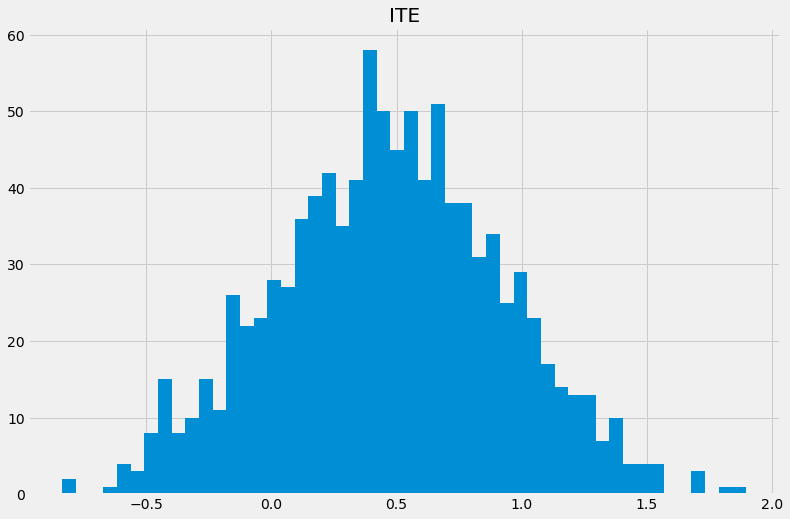

In [0]:
# visualization
ite_df.hist(column ='ITE', bins=50, grid=True, figsize=(12, 8))

### S-Learner ATE - Average Treatment Effect

Prosecan efekat tretmana (ATE) za populaciju je prosek individualnog efekta tretmana.

In [0]:
# Calculate ATE
ATE = ite.mean()

# Print out results
print(f'The average treatment effect (ATE) is {ATE:.2f}')

The average treatment effect (ATE) is 0.47


### Segmentacija klijenata

Uplift model deli klijente u 4 grupe na osnovu inkrementalnih promena izazvanih tretmanom koji primenimo nad njima. Uobicajena primena uplift modela je u marketinske svrhe.
* Persuadables - lako ubedljivi klijenti/oni koji ce kupiti proizvod ako su tretirani, u suprotnom nece. U nasem slucaju bice definisani kao oni klijenti kojima je ITE > 0.5
* Sleeping dogs - klijenti koji ce kupovati proizvod ukoliko ih ne ometamo, ukoliko ih tretiramo nece kupovati. U nasem slucaju su oni sa ITE < -0.5.
* Lost Causes - klijenti koji nece kupovati nevezano da li su tretirani ili nisu.
* Sure things - klijenti koji ce sigurno kupiti proizvod bez obzira da li su tretirani ili nisu.

Poslednja dva slucaja cemo grupisati kao *no_impact* ukoliko je -0.5 < ITE < 0.5. Njihov efekat tretmana je blizu 0, smatramo da kontaktiranjem ovih klijenata mozemo samo da izgubimo resurse.

In [0]:
# Create the segmentation function
def segmentation(x):
  if x < -0.5:
    return 'sleeping-dog'
  elif x > 0.5:
    return 'persuadable'
  else:
    return 'no_impact'

# Apply the function 
ite_df['segment'] = ite_df['ITE'].apply(segmentation)

# Take a look at the data
ite_df.head()

,ITE,with_treatment_predict,without_treatment_predict,segment
0,-0.022509,0.935674,0.958183,no_impact
1,-0.560047,0.867569,1.427616,sleeping-dog
2,-0.150755,0.667450,0.818205,no_impact
3,0.207543,1.372787,1.165244,no_impact
4,0.134130,0.366198,0.232068,no_impact


Out[11]: <AxesSubplot:xlabel='segment', ylabel='count'>

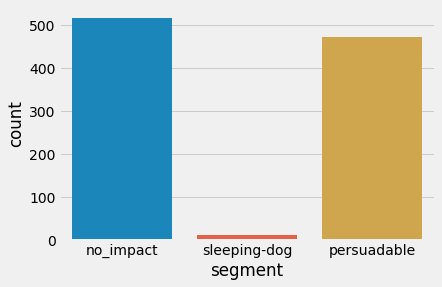

In [0]:
# Visualization
sns.countplot(x=ite_df['segment'])

Na ovaj nacin se mogu optimizovati marketinske kampanje i klijenti koji bi bili kontaktirani.